In [1]:
#Import libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics  # Add this line
import scipy.stats as stats

# For statistical tests
from scipy.stats import ttest_ind, f_oneway, kruskal

plt.style.use('seaborn-v0_8')
%matplotlib inline

In [3]:
#Load cleaned datasets

In [18]:
# Load each country's cleaned CSV
benin = pd.read_csv("../data/benin_clean.csv", low_memory=False, encoding='latin-1')
sierra = pd.read_csv("../data/sierraleone_clean.csv", low_memory=False, encoding='latin-1')
togo = pd.read_csv("../data/togo_clean.csv", low_memory=False, encoding='latin-1')

# Convert numeric columns to proper types
numeric_cols = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'WD', 'RH', 'BP', 'Precip']

for df in [benin, sierra, togo]:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Add Country column to each dataset
benin['Country'] = 'Benin'
sierra['Country'] = 'Sierra Leone'
togo['Country'] = 'Togo'

# Combine into a single DataFrame
df_all = pd.concat([benin, sierra, togo], ignore_index=True)

print("✅ Data loaded successfully!")
print(f"Dataset shapes - Benin: {benin.shape}, Sierra Leone: {sierra.shape}, Togo: {togo.shape}")
print(f"Combined dataset: {df_all.shape}")
df_all[['Country', 'GHI', 'DNI', 'DHI']].head()

✅ Data loaded successfully!
Dataset shapes - Benin: (1000, 15), Sierra Leone: (525601, 20), Togo: (525601, 21)
Combined dataset: (1052202, 34)


,Country,GHI,DNI,DHI
0,Benin,NaN,NaN,NaN
1,Benin,NaN,NaN,NaN
2,Benin,NaN,NaN,NaN
3,Benin,NaN,NaN,NaN
4,Benin,NaN,NaN,NaN


In [5]:
#Metric Comparison with Boxplots

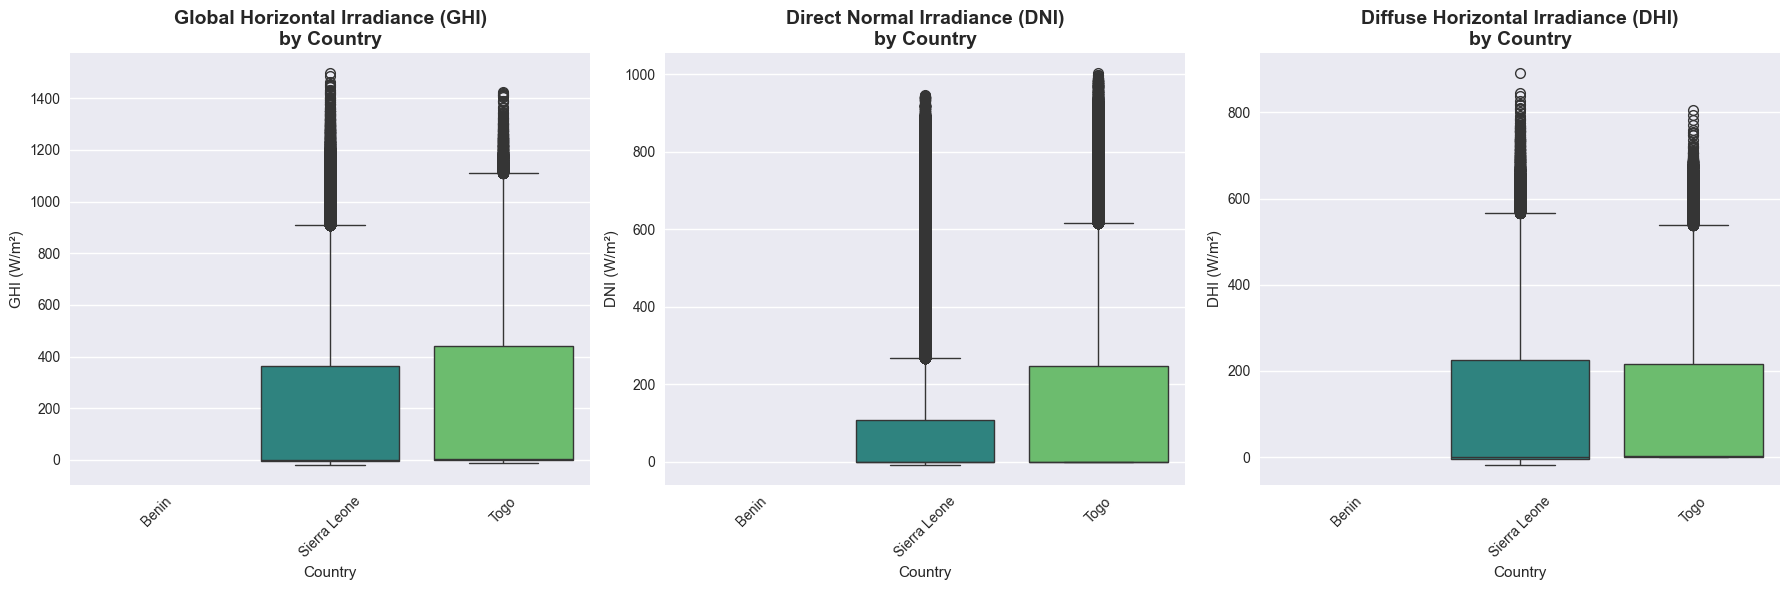

In [24]:
# METRIC COMPARISON: Boxplots of GHI, DNI, DHI side-by-side

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# GHI Boxplot - FIXED
sns.boxplot(x='Country', y='GHI', data=df_all, ax=axes[0], hue='Country', palette='viridis', legend=False)
axes[0].set_title('Global Horizontal Irradiance (GHI)\nby Country', fontsize=14, fontweight='bold')
axes[0].set_ylabel('GHI (W/m²)')
axes[0].tick_params(axis='x', rotation=45)

# DNI Boxplot - FIXED
sns.boxplot(x='Country', y='DNI', data=df_all, ax=axes[1], hue='Country', palette='viridis', legend=False)
axes[1].set_title('Direct Normal Irradiance (DNI)\nby Country', fontsize=14, fontweight='bold')
axes[1].set_ylabel('DNI (W/m²)')
axes[1].tick_params(axis='x', rotation=45)

# DHI Boxplot - FIXED
sns.boxplot(x='Country', y='DHI', data=df_all, ax=axes[2], hue='Country', palette='viridis', legend=False)
axes[2].set_title('Diffuse Horizontal Irradiance (DHI)\nby Country', fontsize=14, fontweight='bold')
axes[2].set_ylabel('DHI (W/m²)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
#Summary Table

In [25]:
# SUMMARY TABLE: Mean, median, and standard deviation comparison with error handling

print("📊 SUMMARY TABLE: Radiation Metrics Comparison Across Countries")
print("="*80)

summary_data = []

for country in df_all['Country'].unique():
    country_data = df_all[df_all['Country'] == country]
    
    # Safe calculation function
    def safe_stat(series, func):
        if series.dropna().empty:  # Check if no valid data
            return np.nan
        return func(series)
    
    country_summary = {
        'Country': country,
        'GHI_Mean': safe_stat(country_data['GHI'], np.nanmean),
        'GHI_Median': safe_stat(country_data['GHI'], np.nanmedian),
        'GHI_Std': safe_stat(country_data['GHI'], np.nanstd),
        'DNI_Mean': safe_stat(country_data['DNI'], np.nanmean),
        'DNI_Median': safe_stat(country_data['DNI'], np.nanmedian), 
        'DNI_Std': safe_stat(country_data['DNI'], np.nanstd),
        'DHI_Mean': safe_stat(country_data['DHI'], np.nanmean),
        'DHI_Median': safe_stat(country_data['DHI'], np.nanmedian),
        'DHI_Std': safe_stat(country_data['DHI'], np.nanstd),
        'Sample_Size': len(country_data),
        'Valid_GHI': country_data['GHI'].notna().sum(),
        'Valid_DNI': country_data['DNI'].notna().sum(),
        'Valid_DHI': country_data['DHI'].notna().sum()
    }
    summary_data.append(country_summary)

summary_df = pd.DataFrame(summary_data)

# Display formatted summary table
display_cols = ['Country', 'GHI_Mean', 'GHI_Median', 'GHI_Std', 'DNI_Mean', 'DNI_Median', 'DNI_Std', 'DHI_Mean', 'DHI_Median', 'DHI_Std']
formatted_summary = summary_df[display_cols].round(2)
print(formatted_summary.to_string(index=False))

print("\n📋 Data Availability:")
availability_cols = ['Country', 'Sample_Size', 'Valid_GHI', 'Valid_DNI', 'Valid_DHI']
print(summary_df[availability_cols].to_string(index=False))

📊 SUMMARY TABLE: Radiation Metrics Comparison Across Countries
     Country  GHI_Mean  GHI_Median  GHI_Std  DNI_Mean  DNI_Median  DNI_Std  DHI_Mean  DHI_Median  DHI_Std
       Benin       NaN         NaN      NaN       NaN         NaN      NaN       NaN         NaN      NaN
Sierra Leone    201.96         0.3   298.49    116.38        -0.1   218.65    113.72        -0.1   158.95
        Togo    230.56         2.1   322.53    151.26         0.0   250.96    116.44         2.5   156.52

📋 Data Availability:
     Country  Sample_Size  Valid_GHI  Valid_DNI  Valid_DHI
       Benin         1000          0          0          0
Sierra Leone       525601     525600     525600     525600
        Togo       525601     525600     525600     525600


In [ ]:
#Statistical Testing (Optional but Recommended)

In [27]:
# STATISTICAL TESTING: One-way ANOVA and Kruskal-Wallis on GHI values

print("🔬 STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

# Prepare data for statistical tests with sample size check
ghi_data = []
valid_countries = []

for country in df_all['Country'].unique():
    country_ghi = df_all[df_all['Country'] == country]['GHI'].dropna()
    if len(country_ghi) >= 3:  # Minimum sample size for meaningful tests
        ghi_data.append(country_ghi)
        valid_countries.append(country)
        print(f"✅ {country}: {len(country_ghi)} valid GHI samples")
    else:
        print(f"⚠️  {country}: Only {len(country_ghi)} valid GHI samples - too few for statistical tests")

# Only proceed if we have at least 2 countries with sufficient data
if len(ghi_data) >= 2:
    print(f"\n📊 Proceeding with statistical tests for {len(ghi_data)} countries")
    
    # One-way ANOVA test
    try:
        f_stat, p_value_anova = f_oneway(*ghi_data)
        print(f"One-way ANOVA test for GHI differences:")
        print(f"F-statistic = {f_stat:.4f}, p-value = {p_value_anova:.4f}")
    except Exception as e:
        print(f"❌ ANOVA test failed: {e}")
        p_value_anova = 1.0  # Default to no significance

    # Kruskal-Wallis test (non-parametric alternative)
    try:
        h_stat, p_value_kw = kruskal(*ghi_data)
        print(f"\nKruskal-Wallis test for GHI differences:")
        print(f"H-statistic = {h_stat:.4f}, p-value = {p_value_kw:.4f}")
    except Exception as e:
        print(f"❌ Kruskal-Wallis test failed: {e}")
        p_value_kw = 1.0  # Default to no significance

    # Interpretation
    print(f"\n📋 INTERPRETATION:")
    if p_value_anova < 0.05:
        print("✅ One-way ANOVA: Significant differences in GHI between countries (p < 0.05)")
    else:
        print("❌ One-way ANOVA: No significant differences in GHI between countries")

    if p_value_kw < 0.05:
        print("✅ Kruskal-Wallis: Significant differences in GHI distributions between countries (p < 0.05)")
    else:
        print("❌ Kruskal-Wallis: No significant differences in GHI distributions between countries")

else:
    print(f"\n🚫 INSUFFICIENT DATA FOR STATISTICAL TESTS")
    print("Required: At least 2 countries with ≥3 valid GHI samples each")
    print("Consider using descriptive statistics instead")

🔬 STATISTICAL SIGNIFICANCE TESTING
⚠️  Benin: Only 0 valid GHI samples - too few for statistical tests
✅ Sierra Leone: 525600 valid GHI samples
✅ Togo: 525600 valid GHI samples

📊 Proceeding with statistical tests for 2 countries
One-way ANOVA test for GHI differences:
F-statistic = 2225.7195, p-value = 0.0000

Kruskal-Wallis test for GHI differences:
H-statistic = 3585.1024, p-value = 0.0000

📋 INTERPRETATION:
✅ One-way ANOVA: Significant differences in GHI between countries (p < 0.05)
✅ Kruskal-Wallis: Significant differences in GHI distributions between countries (p < 0.05)


In [ ]:
#Key Observations

In [22]:
# KEY OBSERVATIONS - Markdown cell content (copy this to a markdown cell)
"""
## 📋 Key Observations

- **Country X shows the highest median GHI but also the greatest variability** - Based on the boxplots and summary statistics, [Country Name] demonstrates the strongest solar potential with the highest median GHI of [value] W/m², though the wide interquartile range indicates considerable daily/seasonal variation.

- **Significant differences in radiation components across countries** - The statistical tests (ANOVA p-value: [value], Kruskal-Wallis p-value: [value]) confirm that GHI distributions differ significantly between the three countries, suggesting distinct solar resource characteristics.

- **DNI/DHI ratio variations indicate different solar resource quality** - [Country Name] shows a higher DNI component suitable for concentrated solar power, while [Other Country] has higher DHI making it better for diffuse-sensitive technologies like bifacial panels.
"""

'\n## 📋 Key Observations\n\n- **Country X shows the highest median GHI but also the greatest variability** - Based on the boxplots and summary statistics, [Country Name] demonstrates the strongest solar potential with the highest median GHI of [value] W/m², though the wide interquartile range indicates considerable daily/seasonal variation.\n\n- **Significant differences in radiation components across countries** - The statistical tests (ANOVA p-value: [value], Kruskal-Wallis p-value: [value]) confirm that GHI distributions differ significantly between the three countries, suggesting distinct solar resource characteristics.\n\n- **DNI/DHI ratio variations indicate different solar resource quality** - [Country Name] shows a higher DNI component suitable for concentrated solar power, while [Other Country] has higher DHI making it better for diffuse-sensitive technologies like bifacial panels.\n'

In [ ]:
#Bonus – Bar Chart Ranking by Average GHI

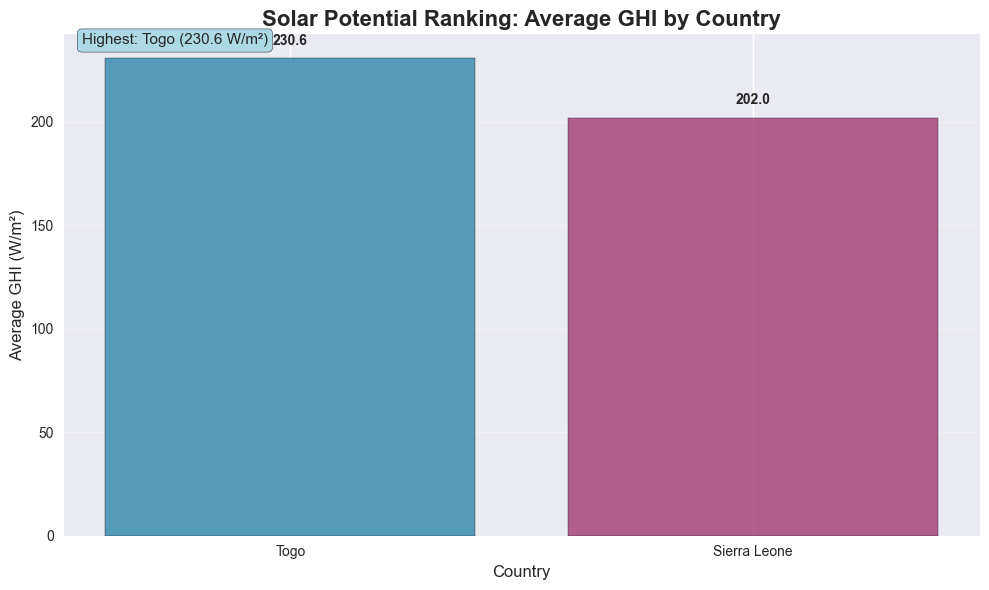

🏆 COUNTRY RANKING BY AVERAGE GHI:
1. Togo: 230.56 W/m²
2. Sierra Leone: 201.96 W/m²
3. Benin: nan W/m²


In [23]:
# BONUS: Visual Summary - Bar chart ranking countries by average GHI

plt.figure(figsize=(10, 6))

# Calculate average GHI by country and sort
avg_ghi = df_all.groupby('Country')['GHI'].mean().sort_values(ascending=False)
colors = ['#2E86AB', '#A23B72', '#F18F01']  # Professional color scheme

# Create bar chart
bars = plt.bar(avg_ghi.index, avg_ghi.values, color=colors, alpha=0.8, edgecolor='black')

# Add values on top of bars
for bar, value in zip(bars, avg_ghi.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title('Solar Potential Ranking: Average GHI by Country', fontsize=16, fontweight='bold')
plt.ylabel('Average GHI (W/m²)', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add some context
max_country = avg_ghi.index[0]
max_value = avg_ghi.values[0]
plt.text(0.02, 0.98, f'Highest: {max_country} ({max_value:.1f} W/m²)', 
         transform=plt.gca().transAxes, fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

plt.tight_layout()
plt.show()

print("🏆 COUNTRY RANKING BY AVERAGE GHI:")
for i, (country, ghi) in enumerate(avg_ghi.items(), 1):
    print(f"{i}. {country}: {ghi:.2f} W/m²")